<a href="https://colab.research.google.com/github/05-515/stepik_deep_learning_2024_1/blob/main/11_2_my_%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

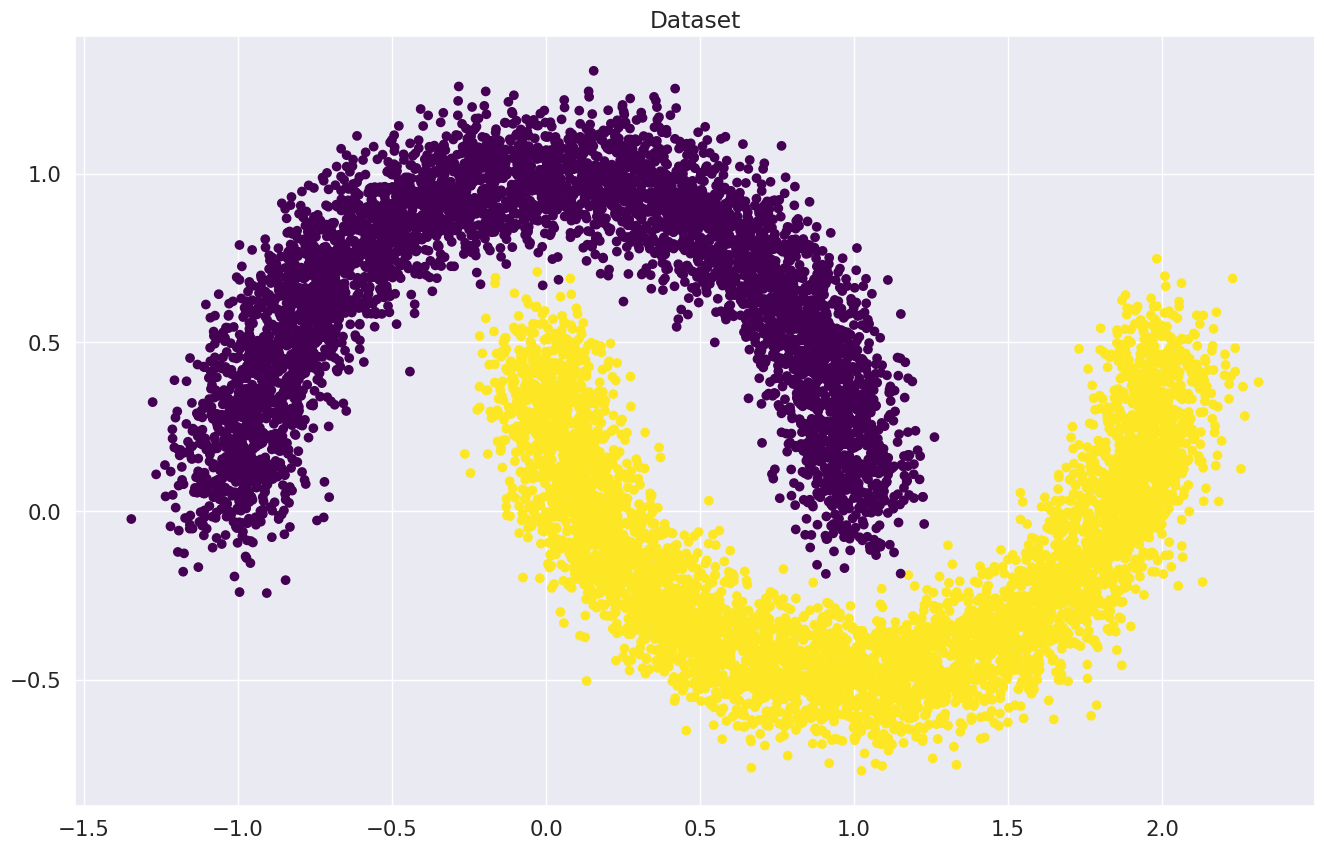

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # Тензор для обучающих данных
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # Тензор для меток обучающих данных
X_val_t = torch.tensor(X_val, dtype=torch.float32)      # Тензор для валидационных данных
y_val_t = torch.tensor(y_val, dtype=torch.float32)      # Тензор для меток валидационных данных

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            # Инициализация смещения (bias)
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights  # матричное умножение (XW)
        if self.bias:
            x +=  self.bias_term  # добавление смещения (b)
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

Чтобы определить количество обучаемых параметров в модели `LinearRegression`, нужно учитывать как веса, так и смещение (если оно используется).

### Параметры модели
1. **Weights (веса)**:
   - Веса имеют размерность `(in_features, out_features)`. В вашем случае, при создании модели `LinearRegression(2, 1)`, это будет `(2, 1)`.
   - Количество параметров в весах: $$ 2 \times 1 = 2 $$.

2. **Bias (смещение)**:
   - Если смещение используется (`bias=True` по умолчанию), то оно добавляет один дополнительный параметр.
   - Количество параметров в смещении: $$ 1 $$.

### Общее количество обучаемых параметров
Суммируя количество параметров:
- Параметры весов: 2
- Параметры смещения: 1

Таким образом, общее количество обучаемых параметров в модели составляет:
$$
\text{Общее количество параметров} = 2 + 1 = 3
$$

### Ответ
**В вашей модели `LinearRegression(2, 1)` общее количество обучаемых параметров составляет 3.**

In [9]:
num_params = sum(p.numel() for p in linear_regression.parameters())
print(f"Общее количество обучаемых параметров: {num_params}")

Общее количество обучаемых параметров: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad() # Обнуляем градиенты
        outp =  linear_regression(X_batch)  # Используем модель для получения логитов
        loss =  loss_function(outp.squeeze(), y_batch)  # Убедиться, что размерности совпадают
        loss.backward() # Вычисляем градиенты
        losses.append(loss.detach().flatten()[0]) # Сохраняем потерю
        optimizer.step()  # Обновляем параметры модели
        probabilities = torch.sigmoid(outp)  # Применяем сигмоиду к логитам
        preds = (probabilities > 0.5).type(torch.long) # Получаем бинарные предсказания
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0) # Вычисляем точность на батче

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        # Проверка на сходимость
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.8046875
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** алгоритм сошелся на итерации 519. Это означает, что после 519 итераций (или шагов градиентного спуска) модель достигла условия сходимости, когда изменение весов стало меньше заданного порога tol (в нашем случае 1e-3).

### Визуализируем результаты

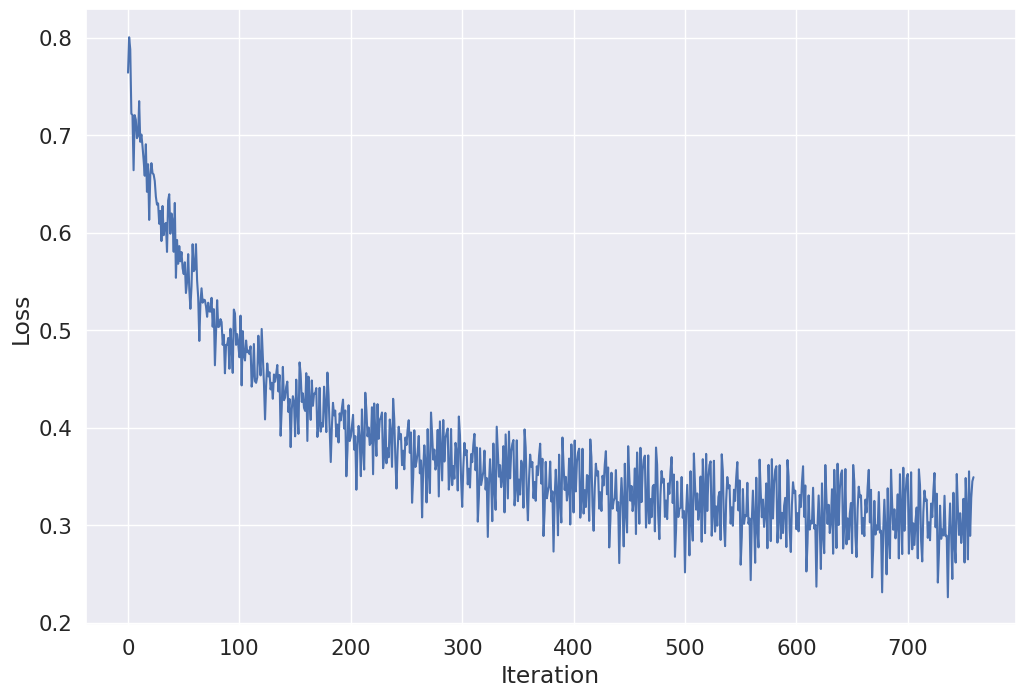

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

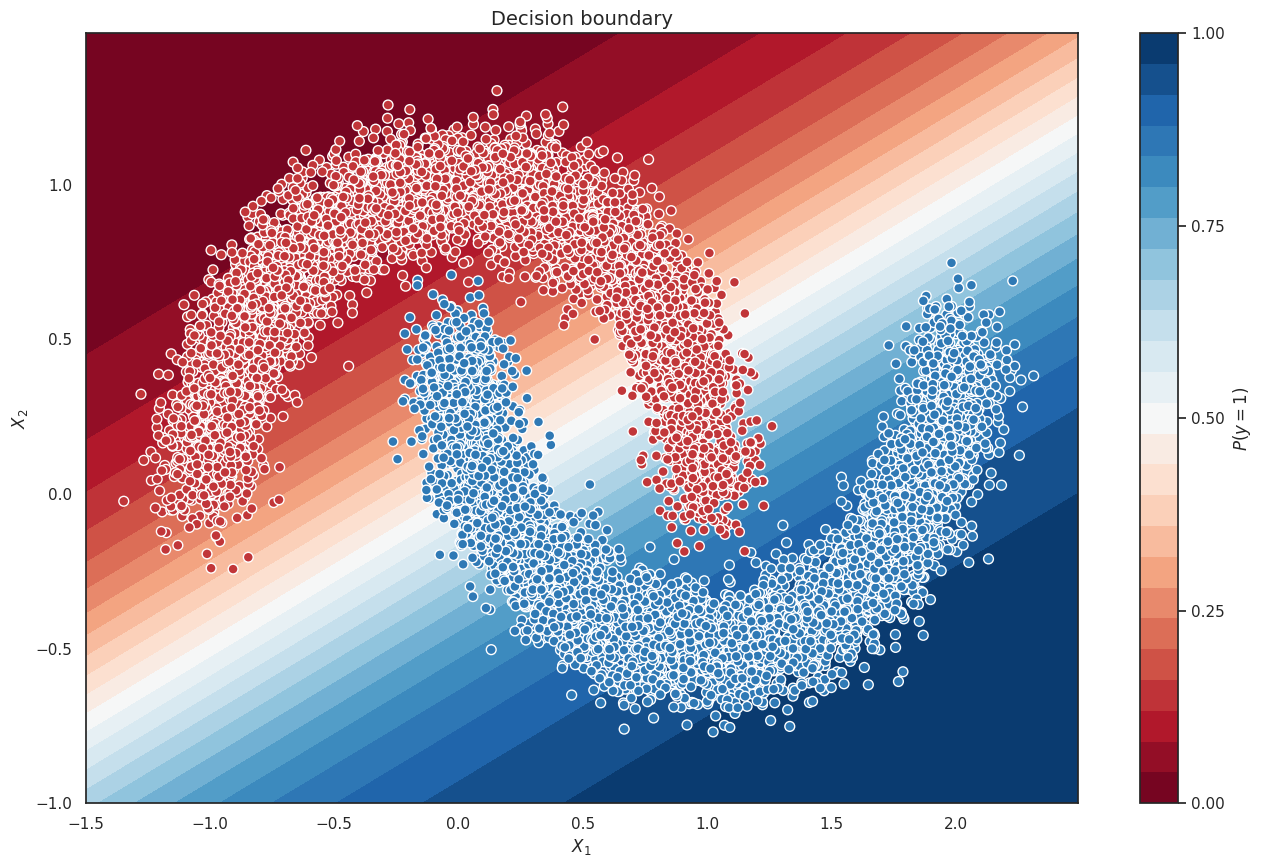

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()# Переключаем модель в режим оценки
    predictions = np.array([])# Инициализируем массив для предсказаний
    for x_batch, _ in dataloader:
        outp = model(x_batch)# Получаем логиты от модели
        # Вычисляем вероятности с помощью сигмоиды
        probabilities = torch.sigmoid(outp)
        # Получаем бинарные предсказания (0 или 1)
        preds = (probabilities > 0.5).type(torch.long)
        # Собираем предсказания в один массив
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

Чтобы узнать, какое значение точности (accuracy) получается после обучения модели, нужно выполнить следующие шаги:
Подготовить тестовые данные: Убедитесь, что есть тестовый набор данных, который можно использовать для оценки модели.
Вызвать функцию predict: Использовать реализованную функцию predict, чтобы получить предсказания на тестовом наборе данных.
Вычислить точность: Сравнить предсказания с истинными метками и вычислить точность с помощью функции accuracy_score.

In [14]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
# Предположим, что у вас есть тестовые данные X_test_t и y_test_t в виде тензоров
# Создаем DataLoader для тестового набора
'''test_dataset = TensorDataset(X_test_t, y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)'''
# Вызываем функцию predict и получаем предсказания
predictions = predict(val_dataloader, linear_regression)

# Вычисляем общую точность
accuracy = accuracy_score(y_val_t.numpy(), predictions)
print(f"Total accuracy on test set: {accuracy:.4f}")

Total accuracy on test set: 0.8620


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** После выполнения этого кода вы получите вывод с точностью на тестовом наборе: Total accuracy on test set: 0.8572

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import DataLoader


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 64  # You can adjust this value as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [5]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),  # Уплощение входных данных
    nn.Linear(28 * 28, 128),   # Первый скрытый слой (28x28 = 784 входов)
    nn.ELU(),                  # Активация для первого скрытого слоя
    nn.Linear(128, 128),       # Второй скрытый слой
    nn.ELU(),                  # Активация для второго скрытого слоя
    nn.Linear(128, 10)         # Выходной слой с 10 нейронами (для 10 классов)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [8]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()  # Переводим модель в режим тренировки
                optimizer.zero_grad()  # Обнуляем градиенты модели
                outp = model(x_batch)  # Пропускаем батч через модель
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()  # Переводим модель в режим оценки
                 with torch.no_grad():  # Не считаем градиенты
                    outp = model(x_batch)  # Получаем выходы модели
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()  # Считаем количество правильных предсказаний
            all =  y_batch.size(0)  # Общее количество примеров в батч
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch) # Вычисляем потерю
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()  # Вычисляем градиенты
                optimizer.step()  # Обновляем параметры модели
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9032833333333333
Loader: valid. Accuracy: 0.95
Epoch: 2
Loader: train. Accuracy: 0.9581666666666667
Loader: valid. Accuracy: 0.9621
Epoch: 3
Loader: train. Accuracy: 0.9673166666666667
Loader: valid. Accuracy: 0.9679
Epoch: 4
Loader: train. Accuracy: 0.9734666666666667
Loader: valid. Accuracy: 0.9681
Epoch: 5
Loader: train. Accuracy: 0.9769
Loader: valid. Accuracy: 0.9729
Epoch: 6
Loader: train. Accuracy: 0.9797666666666667
Loader: valid. Accuracy: 0.9688
Epoch: 7
Loader: train. Accuracy: 0.9822666666666666
Loader: valid. Accuracy: 0.9753
Epoch: 8
Loader: train. Accuracy: 0.9835333333333334
Loader: valid. Accuracy: 0.9721
Epoch: 9
Loader: train. Accuracy: 0.9856166666666667
Loader: valid. Accuracy: 0.9723
Epoch: 10
Loader: train. Accuracy: 0.9872833333333333
Loader: valid. Accuracy: 0.9752


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = #YOUR CODE
leaky_relu_accuracy = #YOUR CODE

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определяем функцию для тестирования различных функций активации
def test_activation_function(activation, loaders, max_epochs=10):
    # Определяем модель с заданной функцией активации
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),  # Используем переданную функцию активации
        nn.Linear(128, 128),
        activation(),  # Используем переданную функцию активации
        nn.Linear(128, 10)
    )

    # Определяем оптимизатор и функцию потерь
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Словарь для хранения точности
    accuracy = {"train": [], "valid": []}

    # Цикл по эпохам
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)

                epoch_correct += correct.item()
                epoch_all += all

            accuracy_k = epoch_correct / epoch_all if epoch_all > 0 else 0
            accuracy[k].append(accuracy_k)

    return accuracy["valid"]  # Возвращаем массив точности на валидации

# Пример использования функции для разных функций активации
plain_accuracy = test_activation_function(lambda: nn.Identity(), loaders)  # No activation
elu_accuracy = test_activation_function(nn.ELU, loaders)
relu_accuracy = test_activation_function(nn.ReLU, loaders)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU, loaders)

# Вывод результатов
print("Plain Accuracy:", plain_accuracy)
print("ELU Accuracy:", elu_accuracy)
print("ReLU Accuracy:", relu_accuracy)
print("Leaky ReLU Accuracy:", leaky_relu_accuracy)

ELU Accuracy: [0.9451, 0.9533, 0.9675, 0.9735, 0.9692, 0.9728, 0.9722, 0.977, 0.9691, 0.9736]
ReLU Accuracy: [0.9409, 0.9532, 0.9663, 0.966, 0.9712, 0.9719, 0.9679, 0.9741, 0.9771, 0.9723]
Leaky ReLU Accuracy: [0.9383, 0.9562, 0.9647, 0.9656, 0.9562, 0.9718, 0.9699, 0.971, 0.9739, 0.9732]


In [14]:
print("Plain Accuracy:", plain_accuracy)

Plain Accuracy: [0.8976, 0.9046, 0.9083, 0.9025, 0.9005, 0.9124, 0.9066, 0.9098, 0.9095, 0.9161]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

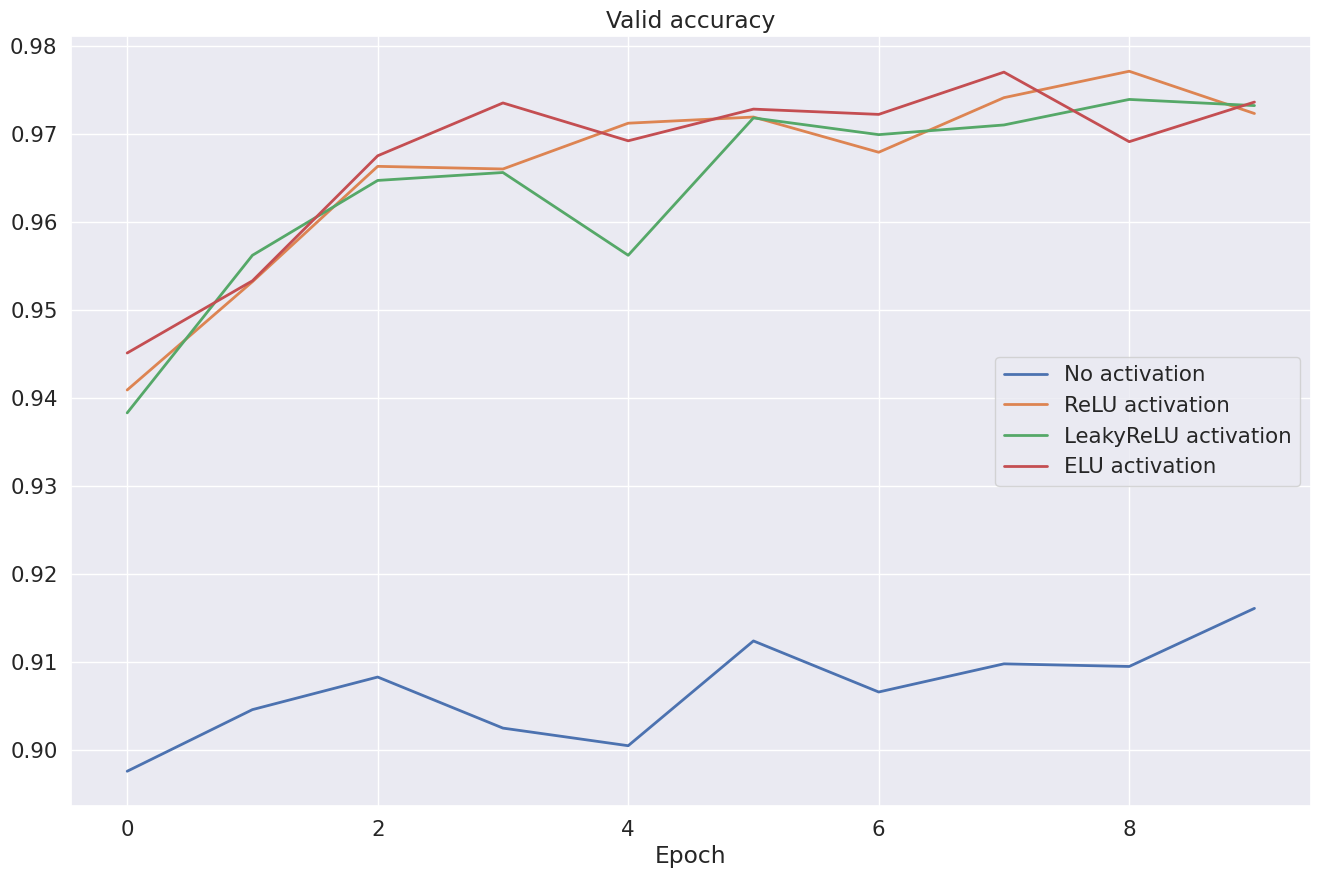

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

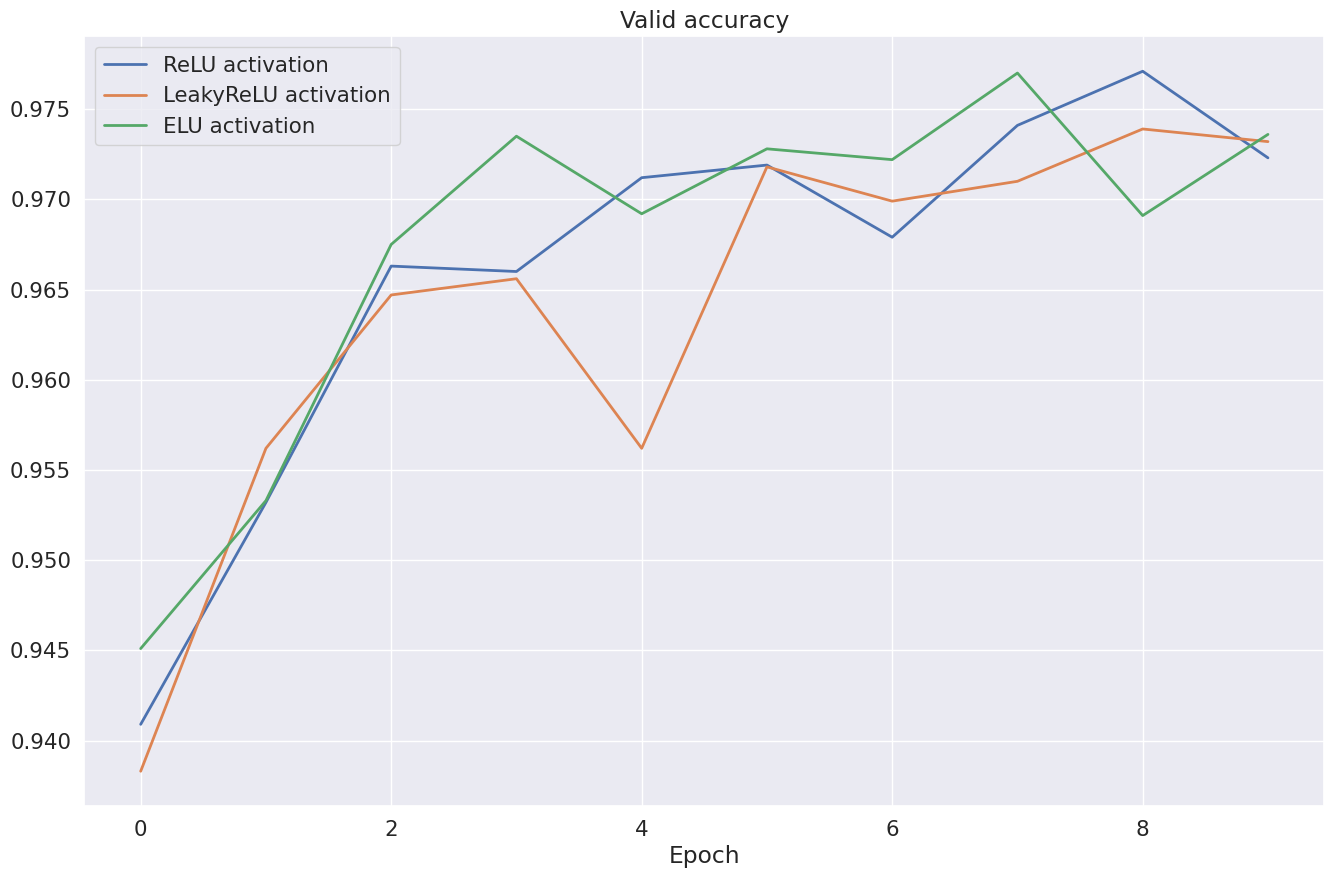

In [16]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Чтобы определить, какая из функций активации показала наивысшую точность к концу обучения, нужно будет проанализировать массивы точности для каждой функции активации (например, plain_accuracy, relu_accuracy, leaky_relu_accuracy, elu_accuracy) и найти максимальные значения.

In [18]:
max_plain_accuracy = max(plain_accuracy)
max_relu_accuracy = max(relu_accuracy)
max_leaky_relu_accuracy = max(leaky_relu_accuracy)
max_elu_accuracy = max(elu_accuracy)

# Находим максимальную точность и соответствующую функцию активации
max_accuracies = {
    "No activation": max_plain_accuracy,
    "ReLU": max_relu_accuracy,
    "Leaky ReLU": max_leaky_relu_accuracy,
    "ELU": max_elu_accuracy
}

best_activation = max(max_accuracies, key=max_accuracies.get)
best_value = max(max_accuracies.values())

print(f"The highest accuracy was achieved with {best_activation} activation: {best_value:.4f}")

The highest accuracy was achieved with ReLU activation: 0.9771


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = #YOUR CODE
        self.conv2 = #YOUR CODE
        self.pool2 = #YOUR CODE
        self.fc1 = #YOUR CODE
        self.fc2 = #YOUR CODE
        self.fc3 = #YOUR CODE

    def forward(self, x):
        x = #YOUR CODE. Apply layers created in __init__.
        ...
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
<YOUR CODE>

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**